The ODA leverages the periodic nature of the ommatidial lattice found in many compound eyes. By using the 2D Fourier Transform, the ODA eliminates spatial detail that is either much smaller or larger than the ommatidia. With that removed, the ommatidia are a lot simpler to detect.
# The Fourier Transform
The fourier transform decomposes any function or sequence of values into a sequence of sine functions with specific frequencies, amplitudes, and phases. The original function or sequence can often be recovered exactly using the inverse fourier transform. 
![FFT demo](https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif)

This allows for the detection and extraction of periodic components in signals and extends into arbitrarily many dimensions. As a result, we can use the 2D discrete form of the Fourier transform, the Fast Fourier Transform (FFT) and the its inverse (iFFT), to detect the frequency corresponding to the ommatidial diameters and filter out those far above and below. These are both available functions in the numpy.fft library.

For more information on the Fourier Transform see [this wikipedia page](https://en.wikipedia.org/wiki/Fourier_transform) and I highly recommend the following beatiful video by [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw):

In [1]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/r6sGWTCMz2k", width=600, height=400)

# Gratings
The sinusoidal elements of a 2D image are called gratings and, like the sine functions in a 1D FFT, these are represented by a frequency, amplitude, and phase. In addition, 2D gratings have an orientation on the 2D plane, referring to the angle perpendicular to the grating's wavefront.

In the 2D grating, the spatial frequency refers to the number of oscillations from dark to light per degree (measured in cycles/°) and the amplitude refers to the contrast between the brightest and darkest points (maximum of 1). In principal, any digital image can be exactly decomposed into a finite set of these gratings. For instance, see the animation below from [The Python Coding Book](https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/) of how you can increasingly approximate an image of the Big Ben with higher and higher spatial frequencies of different orientations. The final composite is equivalent to the original image.

In [2]:
IFrame(src="https://videopress.com/embed/Z9xWcJw4", width=600, height=400)

To explore what this means for the 2D FFT, here's a class to generate and display gratings. If it imports correctly, the code below should diplay 9 gratings with different spatial frequencies and contrasts. Each grating is assumed to occupy a 180° FOV, so a spatial frequency of 1 cycle/° would display 180 cycles (from dark to light) in the whole image. Contrast is defined as Michelson contrast, which represents the contrast between the darkest (A) and brightest points (B) as (A-B)/(A+B). 

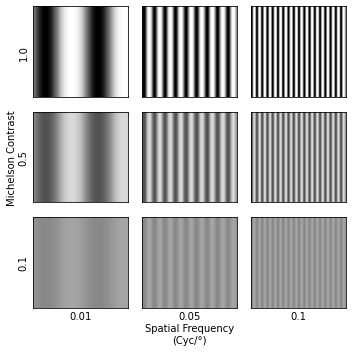

In [3]:
from pylab import *
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from scipy.signal import gaussian
from skimage import feature

%matplotlib inline

red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)


class Grating():
    """Class for making a sinusoidal grating.
    
    
    Parameters
    ----------
    sf : float, default=1
        The number of oscillations from dark to light per degree 
        (in cycles/degree).
    tf : float, default=1
        The number of oscillations from dark to light per second 
        (in Hz) for a moving grating.
    contrast : float, default=1
        The Michelson contrast between the darkest and lightest values, 
        amounting to the amplitude of the sinusoidal component.
    orientation : float, default=0
        The 2D orientation of the grating, perpendicular to its wavefront.
    size : (float, float), default=(1000, 1000)
        The size of the image to generate for displaying the grating. Optional
        If using a specific fov and ioa.
    window : float, default=.2
        The standard deviation of a kernal used for the gaussian window.
    fov : float, default=180
        The field of view that the grating occupies.
    phase : float, default=0
        The offset of the sine function when t=0.
    ioa : float, default=None
        An optional way of defining the image size using the FOV and inter-ommatidial
        or -receptor angle. This supercedes the size parameter.
    """

    def __init__(self, sf=1, tf=0, contrast=1, orientation=0, size=(1000, 1000),
                 window=.2, fov=180, phase=0, ioa=None):
        # sf cyc/deg, oris in degs
        # self.sf = sf*fov*np.pi/(2*size[0])
        # ioa in rads
        self.sf = sf
        self.phase = phase
        self.tf = tf
        self.fov = fov*np.pi/180.
        self.contrast = contrast
        self.orientation = orientation*np.pi/180.
        if ioa is None:
            self.size = size
        else:
            facet_count = int(np.round(float(fov)/float(ioa)))
            self.size = (facet_count, facet_count)
        self.window = window
        self.fig = None
        self.plot = None
        self.make_img(phase)

    def make_img(self, t): 
        # x, y = np.meshgrid(range(size[0]), range(size[1]))
        x, y = np.meshgrid(np.linspace(0, self.fov, self.size[0]),
                           np.linspace(0, self.fov, self.size[0]))
        self.x, self.y = x, y
        sf = self.sf*180./np.pi
        self.arr = self.contrast * np.sin(
            2*np.pi*sf*(x*np.cos(self.orientation) + y*np.sin(self.orientation))
            + 2*np.pi*t*self.tf - self.phase)
        if self.window not in [None, 0]:
            self.gauss_window()
        else:
            self.img = self.arr
       
    def gauss_window(self):
        if self.window < 1:
            gwindow = np.meshgrid(
                gaussian(self.size[0], self.window*self.size[0]),
                gaussian(self.size[1], self.window*self.size[1]))
            gwindow
            self.gwindow = np.product(gwindow, axis=0)
        else:
            self.gwindow = 1
        self.img = self.gwindow * self.arr
            
    def display(self, cmap='Greys', ax=None):
        deg = np.linspace(0, self.fov*180./np.pi, self.size[0])
        if self.fig is None:
            self.fig = plt.figure(figsize=(5,5))
            self.plot = None
        elif plt.fignum_exists(self.fig.number) is False:
            self.fig = plt.figure(figsize=(5,5))
            self.plot = None
        if ax is not None:
            #self.plot = ax.imshow(self.img,cmap=cmap, vmin=-1, vmax=1)
            self.plot = ax.pcolormesh(180/np.pi * self.x, 180/np.pi * self.y, self.img, cmap=cmap, 
                                      vmin=-1, vmax=1, shading='auto')
            plt.xticks([])
            plt.yticks([])
        elif self.plot is None:
            #self.plot = plt.imshow(self.img,cmap=cmap, vmin=-1, vmax=1)
            self.plot = plt.pcolormesh(180/np.pi * self.x, 180/np.pi * self.y, self.img, cmap=cmap, 
                                       vmin=-1, vmax=1, shading='auto')
            plt.xticks([])
            plt.yticks([])
        else:
            self.plot.set_data(self.img)


#3 different gratings with different contrasts and sfs
fig = plt.figure(figsize=(5,5))
i = 1
cs = np.array([.1, .5, 1])
# sfs = np.round(1/np.array([18, 36, 72]), 3)
sfs = np.array([.01, .05, .1])
for c in cs[::-1]:
    for sf in sfs:
        ax = plt.subplot(3, 3, i)
        g = Grating(sf=sf, contrast=c, window=None)
        g.fig = fig
        g.display(ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        if (i - 1)%3 == 0:
            plt.ylabel(c)
        if i > 6:
            plt.xlabel(sf)
        if i == 4:
            plt.ylabel(f"Michelson Contrast\n{c}")
        if i == 8:
            plt.xlabel(f"{sf}\nSpatial Frequency\n(Cyc/°)")
        i += 1
#plt.suptitle("gratings vary by contrast and spatial frequency")
plt.tight_layout()
plt.show()


## Play!
Change the spatial frequency (sf), contrast, phase, and orientation of the grating below to see how it affects the display.

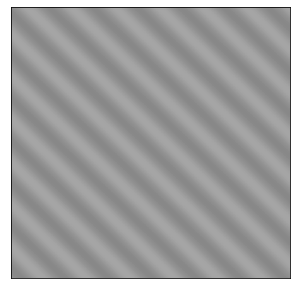

In [4]:
%matplotlib inline
g = Grating(sf=.05, contrast=.1, orientation=45, window=None)# sf in cycles/deg, orientation in deg
g.display()

## The 2D FFT measures grating parameters
We should be able to find the input grating parameters as output of the 2D FFT. First we need to measure how contrast varies as a function of spatial frequency, generating what's called the reciprocal image from the FFT. Let's make a function to plot the reciprocal image and measure some important information like the fundamental spatial frequency and orientation. Note: we are now adding a gaussian window to reduce edge artifacts. 

In [5]:
def process_reciprocal(img, xvals, yvals, num_gratings=1):
    """Process grating information from the reciprocal image of an input array.
    
    
    Parameters
    ----------
    img : np.ndarray, shape=(width, height)
        The image to process.
    xvals : array-like, shape=(width)
        The x-values for each column in img.
    yvals : array-like, shape=(height)
        The y-values for each row in img.
    num_gratings : int, default=1
        The number of fundamental frequencies to check for. Half of the peaks to search for.
    """
    # make a figure with 2x2 subplots
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
    # plot grating on left half
    grating_ax = axes[0]
    grating_ax.set_aspect('equal')
    grating_ax.pcolormesh(xvals, yvals, img, cmap='Greys', shading='auto')
    grating_ax.set_xticks([])
    grating_ax.set_yticks([])
    #grating_ax.set_title(f"Grating (sf={np.round(SF, 3)}, contrast={np.round(CONTRAST)}, orientation={np.round(ORIENTATION)})")
    img = img
    # get 2D fft and calculate reciprocal image and phase plot
    fft = np.fft.fft2(img)
    fft = np.fft.fftshift(fft)
    power = np.absolute(fft)**2
    # convert to contrast value
    # power /= power.max()
    phase = np.angle(fft)
    xfreqs = np.fft.fftfreq(img.shape[0], xvals[0, 1]*180/np.pi)
    xfreqs = np.fft.fftshift(xfreqs)
    yfreqs = np.fft.fftfreq(img.shape[0], yvals[1, 0]*180/np.pi)
    yfreqs = np.fft.fftshift(yfreqs)
    # pad freqs for the colormesh
    xfreqs[-1] = -xfreqs[0]
    yfreqs[-1] = -yfreqs[0]
    xfreq_grid, yfreq_grid = np.meshgrid(xfreqs, yfreqs)
    # plot reciprocal image
    reciprocal_ax = axes[1]
    reciprocal_ax.axhline(0, color='k', linestyle='--', zorder=1)
    reciprocal_ax.axvline(0, color='k', linestyle='--', zorder=1)
    reciprocal_img = reciprocal_ax.pcolormesh(
        xfreq_grid, yfreq_grid, power, cmap='Greys', shading='auto',
        norm=matplotlib.colors.LogNorm())
    reciprocal_ax.set_aspect('equal')
    reciprocal_ax.set_ylabel("Y-frequency (cyc/°)")
    reciprocal_ax.set_xlabel("X-frequency (cyc/°)")
    reciprocal_ax.set_title("Reciprocal Image")
    # add colorbar ax
    divider = make_axes_locatable(reciprocal_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(reciprocal_img, cax=cax, orientation='vertical')
    cbar.set_label('Power', rotation=270)
    # remove splines
    for ax in [grating_ax, reciprocal_ax]:
        for spine in ax.spines.keys():
            ax.spines[spine].set_visible(False)
    # The maxima from the reciprocal image correspond to the x- and y- frequencies of the 
    # fundamental grating. We can find them using the peak_local_max function from the feature 
    # processing library of skimage. 
    width, height = power.shape
    peaks = feature.peak_local_max(power, num_peaks=2*num_gratings)# shape=2x2, (num_peaks, ndim)
    roi = np.arange(-2, 3)
    roi = np.array(np.meshgrid(roi, roi))
    peak_ranges = peaks[..., np.newaxis, np.newaxis] + roi[np.newaxis]# shape=2x2x5x5, (peaks, ndim, xsamples, ysamples)
    xfreq_peaks = xfreq_grid[peaks[:, 0], peaks[:, 1]]#.mean((-1, -2))
    yfreq_peaks = yfreq_grid[peaks[:, 0], peaks[:, 1]]#.mean((-1, -2))
    # annote the maxima in the two frequency domain images
    colors = [red, green, blue]
    top_half = yfreq_peaks >= 0
    angles = np.arctan2(yfreq_peaks, xfreq_peaks)
    include = (angles < np.pi) * (angles >= 0)
    for num, (x, y, color, angle) in enumerate(zip(xfreq_peaks[include], yfreq_peaks[include], colors, angles[include])):
        radius = np.sqrt(x**2 + y**2)
        #reciprocal_ax.plot([0, x], [0, y], color=red)
        reciprocal_ax.arrow(x=0, y=0, dx=x, dy=y, color=color, width=.005, length_includes_head=True, zorder=2)
        # note the coordinates
        reciprocal_ax.annotate(f"({np.round(x, 3)},{np.round(y, 3)})", (x,y), 
                               ha='left', color=color, va='bottom', zorder=2)
        # note the polar angle
        x_lbl = max(0, x/2)
        va = 'bottom'
        ha = 'left'
        if num == 1:
            x_lbl *= -1
            ha='right'
        elif num == 2:
            va = 'top'
        reciprocal_ax.annotate(f"{np.round(angle*180/np.pi, 3)}°", (x_lbl,0), 
                               ha=ha, color=color, va=va, zorder=2)
        # note the radius
        y_lbl = y/2
        x_lbl = x/2
        if angle < np.pi/2:
            ha = 'right'
        else:
            ha = 'left'
        if (angle > np.pi/4) and (angle < 3*np.pi/4):
            va = 'center'
        else:
            va = 'bottom'
        reciprocal_ax.annotate(f"{np.round(radius, 3)}cpd", (x_lbl,y_lbl), 
                               ha=ha, color=color, va=va, zorder=2)
        num += 1
    spatial_freq_peaks = np.sqrt(xfreq_peaks**2 + yfreq_peaks**2)
    xnorm = xfreq_peaks/spatial_freq_peaks
    ynorm = yfreq_peaks/spatial_freq_peaks
    phase_peaks = phase[peak_ranges[:, 0], peak_ranges[:, 1]].mean((-1, -2))
    # zoom in
    dist = min(1.5*abs(spatial_freq_peaks).max(), abs(xfreqs).max())
    reciprocal_ax.set_xlim(-dist, dist)
    reciprocal_ax.set_ylim(-dist, dist)

    # print the point estimates
    orientations = np.arctan2(ynorm, xnorm)
    print(f"max x-frequencies=\t{xfreq_peaks}")
    print(f"max y-frequencies=\t{yfreq_peaks}")
    print(f"spatial frequency=\t{spatial_freq_peaks}")
    print(f"orientation=\t\t{orientations*180/np.pi}")

## Let's test it
Now we have a function that will plot the image and its reciprocal image and extract relevant information about the original image. We can test it with the block below. Feel free to change the input grating parameters (in all caps) and see how it affects the different output parameters. In particular, notice how the polar angle and radius of the red arrow in the reciprocal image corresponds to the grating spatial frequency and orientation.

max x-frequencies=	[-0.24975  0.24975]
max y-frequencies=	[-0.4329  0.4329]
spatial frequency=	[0.49977742 0.49977742]
orientation=		[-119.98163937   60.01836063]


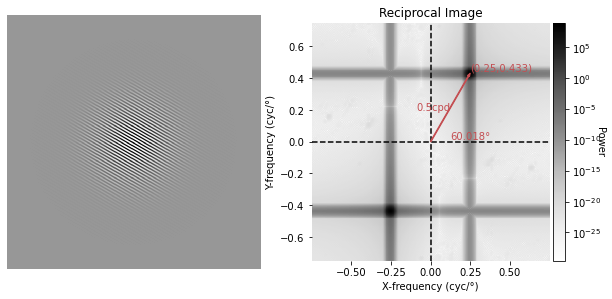

In [6]:
%matplotlib inline
#choose sf, contrast, and orientation of the grating
SF=.5           # cyc/deg
CONTRAST=1      # Michelson (max=1)
ORIENTATION=60  # deg
g = Grating(sf=SF, contrast=CONTRAST, orientation=ORIENTATION, window=.1)
process_reciprocal(g.img, g.x, g.y, num_gratings=1)

## Gratings combine independently
You can do the same analysis for multiple combine gratings, simply look for as many peaks as components. 
### See what happens when you combine two gratings:

max x-frequencies=	[-0.24975  0.24975  0.2997  -0.2997 ]
max y-frequencies=	[-0.4329  0.4329  0.      0.    ]
spatial frequency=	[0.49977742 0.49977742 0.2997     0.2997    ]
orientation=		[-119.98163937   60.01836063    0.          180.        ]


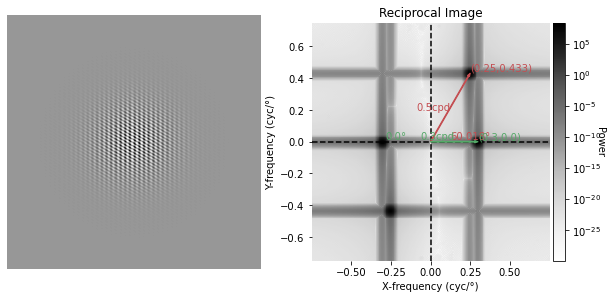

In [7]:
%matplotlib inline
#let's make a plaid, which is the combination of two or more gratings
g1 = Grating(sf=.5, contrast=.5, orientation=60, window=.1)
g2 = Grating(sf=.3, contrast=.5, orientation=0, window=.1)
img = g1.img+g2.img
process_reciprocal(img, g1.x, g1.y, num_gratings=2)

## And 3 gratings:

The maxima from the reciprocal image correspond to the x- and y- frequencies of the fundamental grating. We can find them using the find_peaks function from the signal processing library of scipy. 

max x-frequencies=	[-0.24975  0.24975 -0.2997   0.2997   0.1998  -0.1998 ]
max y-frequencies=	[-0.4329  0.4329  0.      0.     -0.3441  0.3441]
spatial frequency=	[0.49977742 0.49977742 0.2997     0.2997     0.39790055 0.39790055]
orientation=		[-119.98163937   60.01836063  180.            0.          -59.85861445
  120.14138555]


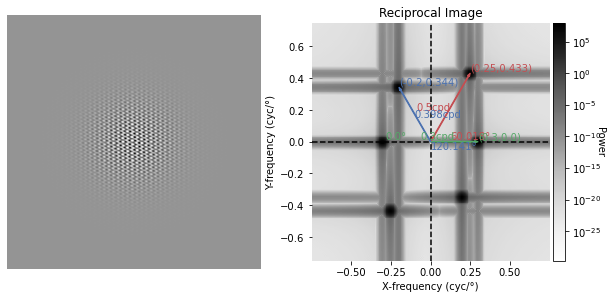

In [8]:
%matplotlib inline
#let's make a plaid, which is the combination of two or more gratings
g1 = Grating(sf=.5, contrast=.33, orientation=60, window=.1)
g2 = Grating(sf=.3, contrast=.33, orientation=0, window=.1)
g3 = Grating(sf=.4, contrast=.33, orientation=120, window=.1)
img = g1.img+g2.img+g3.img
process_reciprocal(img, g1.x, g1.y, num_gratings=3)

## Gratings in the compound eye<img src="https://raw.githubusercontent.com/jpcurrea/eye_tools/main/figs/oda_demo.png" alt="drawing" width="200" align='right'/>
Compound eyes often maximize surface area by following a regular arrangement like a hexagonal lattice. The ODA works by finding the gratings corresponding to the axes of the ommatidial lattice. First we identify these fundamental gratings in the reciprocal image using the FFT like we did with the generated gratings earlier. Then we zero out any gratings with spatial frequencies sufficiently above (in effect, those further from the center than) the maximum. Using the inverse FFT, we generate a version of the original image without any higher spatial frequencies (smaller details) than the ommatidial diameters. Finally, we use a peak finding algorithm to find the maxima in this smoothed out version of the original image.


